In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import tensorflow as tf
from tensorflow.keras.utils import Sequence
tf.debugging.set_log_device_placement(False)

#from fl_mnist_implementation_tutorial_utils import *

# To splite the data between 3 clients

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)
        #masks = masks.reshape((masks.shape[0], self.img_size, self.img_size,1))
        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


# Part 2 - Model

In [3]:

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

def Resunetpp(sz = (256, 256, 3)):
    x = Input(sz)
    n_filters = [16, 32, 64, 128, 256]
    c0 = x
    c1 = stem_block(c0, n_filters[0], strides=1)

    ## Encoder
    c2 = resnet_block(c1, n_filters[1], strides=2)
    c3 = resnet_block(c2, n_filters[2], strides=2)
    c4 = resnet_block(c3, n_filters[3], strides=2)

    ## Bridge
    b1 = aspp_block(c4, n_filters[4])

    ## Decoder
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, n_filters[3])

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, n_filters[2])

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, n_filters[1])

    ## output
    outputs = aspp_block(d3, n_filters[0])
    outputs = Conv2D(1, (1, 1), padding="same")(outputs)
    outputs = Activation("sigmoid")(outputs)

    ## Model
    model = Model(x, outputs)
    return model


# Evaluation Metrics


In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# scalling

In [5]:
def weight_scalling_factor(clients_trn_data):
    #get the bs
    bs = 35
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data).numpy()*bs
    return local_count/3626


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = dice_coef_loss(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [6]:



#initialize global model
global_model = Resunetpp()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_1/", img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_2/", img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_3/", img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D("E:/NU/TUsimple/test_set/teest", img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

 activation_3 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_5[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 64)   18496       ['activation_3[0][0]']           
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_8 

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 32, 32, 256)  0           ['batch_normalization_11[0][0]', 
                                                                  'batch_normalization_12[0][0]', 
                                                                  'batch_normalization_13[0][0]', 
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 batch_nor

                                                                                                  
 activation_12 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_21[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 64, 64, 128)  512        ['multiply_5[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 12  36992       ['activation_12[0][0]']          
                                8)                                                                
                                                                                                  
 activatio

                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  9280        ['activation_17[0][0]']          
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_28[0][0]'] 
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64  0          ['conv2d_29[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_30

 conv2d_38 (Conv2D)             (None, 256, 256, 16  4624        ['multiply_9[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 256, 256, 16  64         ['conv2d_35[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 256, 16  64         ['conv2d_36[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 256, 256, 16  64         ['conv2d_37[0][0]']              
 ormalizat

In [7]:
lr = 1e-3
counter = 0
pre_performance = float('inf')
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = Resunetpp() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ").
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights("E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5")
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print("Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5" )
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 27s 736ms/step - loss: 0.7379 - f1: 0.2584 - iou: 0.1579 - dice_coef: 0.2621
Performance Matrix 
15/15 [==============================] - 26s 2s/step - loss: 0.9257 - f1: 0.0000e+00 - iou: 0.0386 - dice_coef: 0.0743
Model loss imporved from inf to 0.9256789088249207
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 23s 639ms/step - loss: 0.5195 - f1: 0.3932 - iou: 0.3375 - dice_coef: 0.4805
Performance Matrix 
15/15 [=====

30/30 [==============================] - 15s 344ms/step - loss: 0.1554 - f1: 0.8510 - iou: 0.7621 - dice_coef: 0.8446
Performance Matrix 
15/15 [==============================] - 11s 620ms/step - loss: 0.8589 - f1: 0.1413 - iou: 0.0813 - dice_coef: 0.1417
Model loss imporved from 0.9107887744903564 to 0.858850359916687
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  11
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 353ms/step - loss: 0.1393 - f1: 0.8652 - iou: 0.7848 - dice_coef: 0.8607
Performance Matrix 
15/15 [==============================] - 10s 609ms/step - loss: 0.7324 - f1: 0.2682 - iou: 0.1664 - dice_coef: 0.2687
Model loss imporved from 0.858850359916687 to 0.732410728931427
M

30/30 [==============================] - 14s 342ms/step - loss: 0.0956 - f1: 0.9050 - iou: 0.8514 - dice_coef: 0.9044
Performance Matrix 
15/15 [==============================] - 10s 607ms/step - loss: 0.1325 - f1: 0.8699 - iou: 0.7895 - dice_coef: 0.8668
Model loss imporved from 0.23369456827640533 to 0.13251349329948425
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  20
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 347ms/step - loss: 0.0847 - f1: 0.9161 - iou: 0.8713 - dice_coef: 0.9153
Performance Matrix 
15/15 [==============================] - 10s 604ms/step - loss: 0.1903 - f1: 0.8121 - iou: 0.7102 - dice_coef: 0.8087
--------------------------------------------------------------

30/30 [==============================] - 14s 345ms/step - loss: 0.0642 - f1: 0.9372 - iou: 0.9103 - dice_coef: 0.9358
Performance Matrix 
15/15 [==============================] - 10s 611ms/step - loss: 0.0711 - f1: 0.9307 - iou: 0.8932 - dice_coef: 0.9285
Model loss imporved from 0.07669079303741455 to 0.07113149017095566
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  30
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 344ms/step - loss: 0.0499 - f1: 0.9509 - iou: 0.9324 - dice_coef: 0.9501
Performance Matrix 
15/15 [==============================] - 10s 618ms/step - loss: 0.0705 - f1: 0.9314 - iou: 0.8930 - dice_coef: 0.9286
Model loss imporved from 0.07113149017095566 to 0.070530526340

30/30 [==============================] - 14s 342ms/step - loss: -0.0136 - f1: 1.0148 - iou: 1.0525 - dice_coef: 1.0136
Performance Matrix 
15/15 [==============================] - 10s 612ms/step - loss: 0.0470 - f1: 0.9466 - iou: 0.9383 - dice_coef: 0.9523
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  50
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 341ms/step - loss: -0.0061 - f1: 1.0060 - iou: 1.0408 - dice_coef: 1.0061
Performance Matrix 
15/15 [==============================] - 10s 617ms/step - loss: 0.0449 - f1: 0.9348 - iou: 0.9469 - dice_coef: 0.9548
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  51
--------------------------

30/30 [==============================] - 14s 342ms/step - loss: -0.0453 - f1: 1.0463 - iou: 1.1239 - dice_coef: 1.0453
Performance Matrix 
15/15 [==============================] - 10s 615ms/step - loss: 0.0341 - f1: 0.9585 - iou: 0.9667 - dice_coef: 0.9654
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  70
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 342ms/step - loss: -0.0507 - f1: 1.0520 - iou: 1.1326 - dice_coef: 1.0507
Performance Matrix 
15/15 [==============================] - 10s 607ms/step - loss: 0.0328 - f1: 0.9617 - iou: 0.9674 - dice_coef: 0.9665
loss didn't imporve, so LR reduced from 0.000125 to 6.25e-05
---------------------------------------------------------------------------------------
---------------------------------------------------------------

30/30 [==============================] - 14s 342ms/step - loss: -0.0525 - f1: 1.0533 - iou: 1.1387 - dice_coef: 1.0525
Performance Matrix 
15/15 [==============================] - 10s 607ms/step - loss: 0.0419 - f1: 0.9507 - iou: 0.9519 - dice_coef: 0.9573
loss didn't imporve, so LR reduced from 3.125e-05 to 1.5625e-05
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  81
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 342ms/step - loss: -0.0525 - f1: 1.0538 - iou: 1.1395 - dice_coef: 1.0525
Performance Matrix 
15/15 [==============================] - 10s 617ms/step - loss: 0.0416 - f1: 0.9515 - iou: 0.9527 - dice_coef: 0.9577
---------------------------------------------------------------------------------------
------------------------------------------------------------

15/15 [==============================] - 10s 608ms/step - loss: 0.0401 - f1: 0.9517 - iou: 0.9560 - dice_coef: 0.9593
loss didn't imporve, so LR reduced from 7.8125e-06 to 3.90625e-06
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  91
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 341ms/step - loss: -0.0685 - f1: 1.0698 - iou: 1.1762 - dice_coef: 1.0685
Performance Matrix 
15/15 [==============================] - 10s 609ms/step - loss: 0.0398 - f1: 0.9522 - iou: 0.9567 - dice_coef: 0.9597
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  92
---------------------------------------------------------------------------------------
30/30 [====

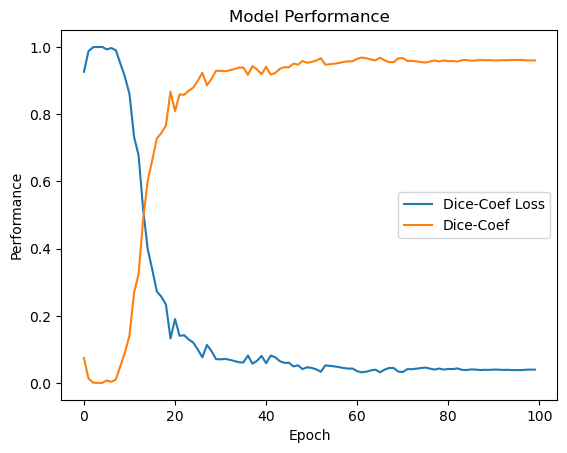

In [8]:

performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

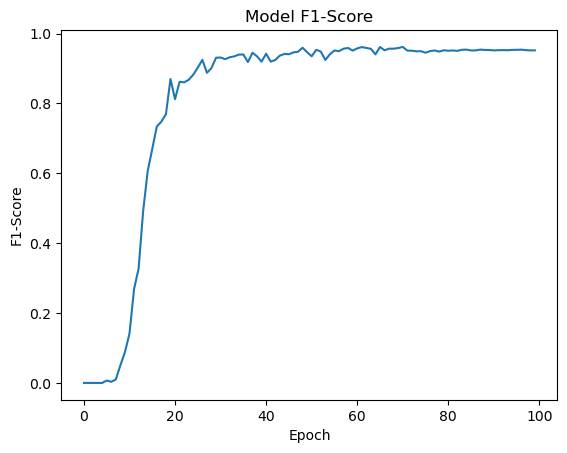

In [9]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

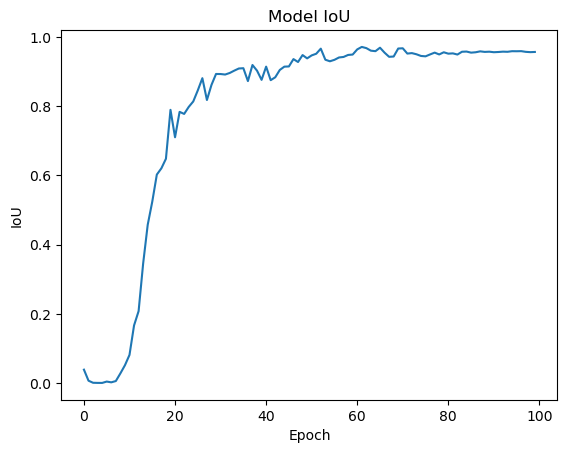

In [10]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [7]:
#val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
global_model = Resunetpp()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)

4/4 [==============================] - 12s 2s/step - loss: 0.0318 - f1: 0.9608 - iou: 0.9708 - dice_coef: 0.9683


In [5]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256, batch_size=10, shuffle=False)
global_model = Resunetpp()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/ResUNet++/GlobalWeights.h5')


In [6]:
X, y = val_generator.__getitem__(0)


predict = global_model.predict(X)
print(predict.shape)

1/1 [==============================] - 10s 10s/step
(10, 256, 256, 1)


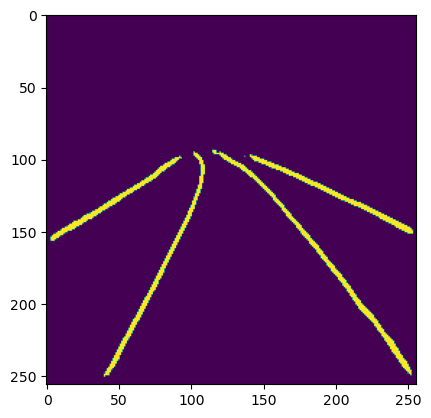

In [7]:
img = predict[5]
plt.imshow(img)

In [1]:
img = X[5]
plt.imshow(img)

NameError: name 'X' is not defined